In [1]:
import pandas as pd
import numpy as np
import nltk
from wrangle import wrangle
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split
from nltk.tokenize.toktok import ToktokTokenizer
import warnings
import re

from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings('ignore')

# Project Objective
Can I build a model that succesfully classifies Magic the Gathering creature cards by the 5 basic colors using attributes from the card

# Executive Summary
There are distinct words in the text that correlate to color

My SVC model provides 66.7% accuracy on unseen data.

SVC beats baseline which was was 21.48%

These models where run soley using the text column to provide an mvp, I am confident that adding power, toughness, converted mana cost, and creature type will provide a higher rate of accuracy for future iterations. 

In [2]:
# For more information on how data was cleaned and preped for this dataframe please vist
# my README.MD where it is extensivley documented
train,validate,test =wrangle()

In [3]:
# Testing my wrangle function
train.shape,validate.shape,test.shape

((5681, 10), (2435, 10), (2030, 10))

In [4]:
#Snapshot
train.head()

,colors,keywords,manaValue,name,power,rarity,subtypes,supertypes,text,toughness
9505,G,Heroic,4.0,Staunch-Hearted Warrior,2,common,"Human,Warrior",None,Heroic — Whenever you cast a spell that target...,2
1525,B,None,2.0,Nezumi Graverobber // Nighteyes the Desecrator,2,uncommon,"Rat,Rogue",None,{1}{1}: Exile target card from an opponents gr...,1
560,G,"Defender,Reach",3.0,Whip Vine,1,common,"Plant,Wall",None,Defender; reach You may choose not to untap t...,4
482,W,Exalted,1.0,Akrasan Squire,1,common,"Human,Soldier",None,Exalted,1
6134,R,Madness,1.0,Blazing Rootwalla,1,uncommon,Lizard,None,{1}: this card gets +2/+0 until end of turn. A...,1


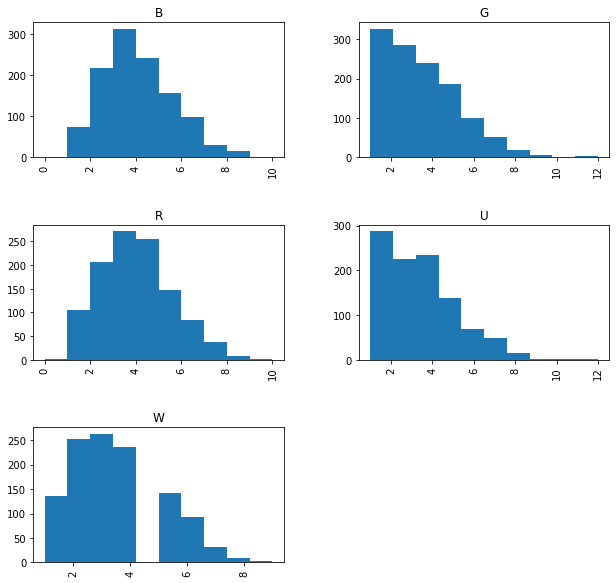

In [5]:
# resource cost by color 

train.manaValue.hist(by=train.colors, figsize=(10,10), bins=10);

Some colors have a normally distibuted mana cost and other colors are more right skewed


Is there a significant difference between the population mean of each color?



The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal and does not need the normalcy of a data set that an ANOVA test would require.

Kruskal-Wallis H-test:

$H_0$: there is no difference in mean mana value between the 5 colors

$H_a$: there is a significant in mean mana value between the 5 colors

In [6]:
alpha = .05
stats.kruskal(    
    train[train.colors == 'B'].manaValue,
    train[train.colors == 'U'].manaValue,
    train[train.colors == 'W'].manaValue,
    train[train.colors == 'R'].manaValue,
    train[train.colors == 'G'].manaValue)


KruskalResult(statistic=19.4388661546566, pvalue=0.0006442815050914629)

We can succesfully reject the null hypothesis. The pvalue of .0006 is less then our aplha of .05, meaning there is a sigificant difference in mana values between the 5 colors

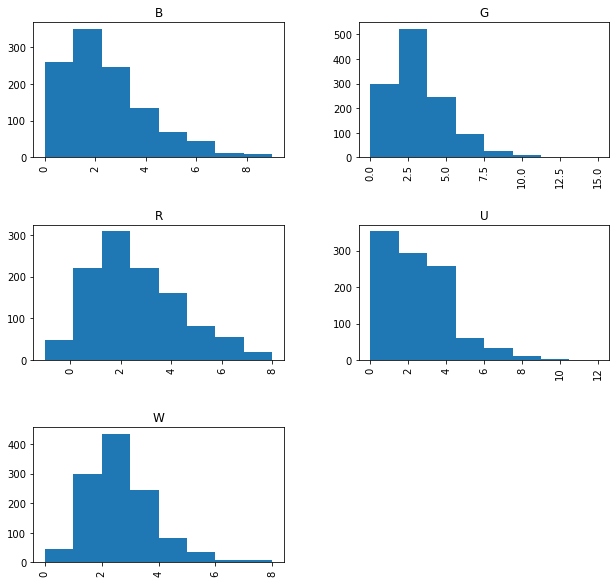

In [7]:
# power by color
train.power = pd.to_numeric(train.power, errors='coerce', downcast = 'integer')

train.power.hist(by=train.colors, figsize=(10,10), bins=8)
plt.show();

Green has the creatures with the most power

Is there statistical evidence that mean power significantly differnet amoung the five colors?

Kruskal-Wallis H-test:

$H_0$: there is no difference in mean power between green and the other colors

$H_a$: there is a significant difference in mean power between green and the other colors

In [8]:
alpha = .05
sample1 = train[train.colors == 'G'].power
sample2 = train[train.colors != 'G'].power
stats.mannwhitneyu(sample1, sample2)

MannwhitneyuResult(statistic=2426463.5, pvalue=1.3522649669066548e-09)

We can succesfully reject the null hypothesis. The pvalue of  is less then our aplha of .05, meaning there is a sigificant difference in power between green the 4 colors other colors

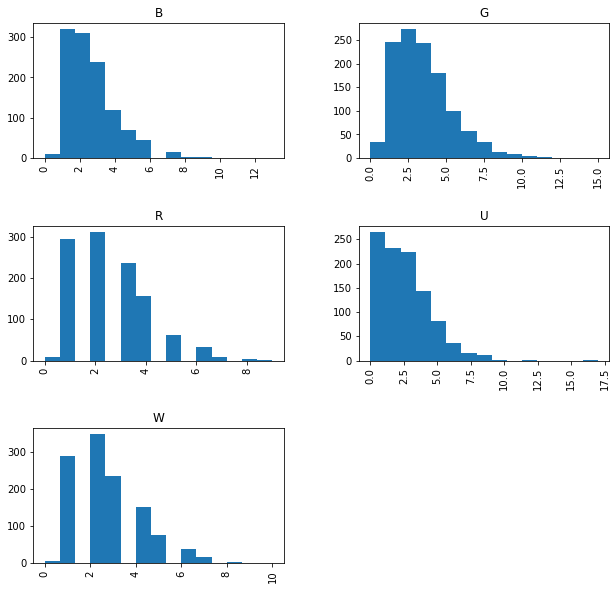

In [9]:
train.toughness = pd.to_numeric(train.toughness, errors='coerce', downcast = 'integer')

train.toughness.hist(by=train.colors, figsize=(10,10), bins=15)
plt.show();

Green and blue appear to have the toughest creatures


In [10]:
alpha = .05
stats.kruskal(    
    train[train.colors == 'B'].toughness,
    train[train.colors == 'U'].toughness,
    train[train.colors == 'W'].toughness,
    train[train.colors == 'R'].toughness,
    train[train.colors == 'G'].toughness)

KruskalResult(statistic=nan, pvalue=nan)

In [11]:
def top_words(thing, num, stop=None):
    '''This function returns the top x words for the dataframe'''
    vectorizer = CountVectorizer(stop_words='english', lowercase=True)
    vectorized_data = vectorizer.fit_transform(thing.text) 
    freqs = [(word, vectorized_data.getcol(idx).sum()) for word, idx 
             in vectorizer.vocabulary_.items()]
    words =  sorted (freqs, key = lambda x: -x[1])
    return [i[0] for i in words[:num]]

print("Top words from all cards")
top_words(train, 10)

Top words from all cards


['card',
 'creature',
 'battlefield',
 'target',
 'turn',
 'control',
 'enters',
 'flying',
 'end',
 'tap']

In [12]:
def top_colors(sliced, num, stop=None):
    '''This function returns the top words for each color and returns a df'''
    label = ["B", "U", "G", "R", "W"]
    df = pd.DataFrame(np.repeat(" ", (num * 5)).reshape((num, 5)), columns=label)
    for l in label:
        top = top_words(sliced.groupby('colors').get_group(l), num, stop)
        for n in range(num):
            df[l][n] = top[n]
    return df

top_colors(train, 26, stop='english')

,B,U,G,R,W
0,card,card,card,card,card
1,creature,flying,creature,turn,creature
2,battlefield,target,battlefield,creature,flying
3,target,creature,control,damage,battlefield
4,turn,battlefield,enters,target,control
5,life,enters,turn,end,turn
6,enters,control,target,deals,target
7,end,turn,end,control,enters
8,player,tap,trample,battlefield,end
9,control,cards,counter,haste,creatures


In [13]:
# This is how vectorization works, ultimatley future iterations will have every other 
#column it the original df scaled and concated to this df giving me 1 extremley large 
# df to run my models on

vectorizer = CountVectorizer()
train_matrix = vectorizer.fit_transform(train.text)

pd.DataFrame(train_matrix.toarray(), columns = vectorizer.get_feature_names())

,10,13,14,15,19,20,25,30,40,__________,...,you,your,youre,youve,yu,zhang,zombie,zombies,zone,zubera
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5676,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
5677,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5678,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5679,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# NOTE: 
### My data is not stemmed, future iterations will stem the wordbag to see if that effects accuracy

In [14]:
# Creating my X_train,X_validate,X_test out of ONLY text, this is for mvp purposes future iterations
# will contain more columns from the original df
vectorizer = CountVectorizer(binary = True, stop_words = 'english')
vectorizer.fit(list(train.text))
X_train = vectorizer.transform(train.text)
X_validate= vectorizer.transform(validate.text)
X_test = vectorizer.transform(test.text)

In [15]:
X_train

<5681x1217 sparse matrix of type '<class 'numpy.int64'>'
	with 45110 stored elements in Compressed Sparse Row format>

In [16]:
# Creating y_train,y_validate, y_test
y_train = train.colors
y_validate = validate.colors
y_test = test.colors

# Modeling
## Baseline

In [17]:
# Lets set a baseline for the dataset to compare everything to. 
# We'll use the most frequent card color as the baseline
train['baseline'] = 'G'
baseline_accuracy = (train.baseline == train.colors).mean()
print(f'Baseline accuracy is {baseline_accuracy:.2%}')

Baseline accuracy is 21.48%


Baseline accuracy is 21.48%, I'm expecting to beat this realativley easily

# Support Vector Classifier
Because everything about NLP is new I also tried a new model, During my 
research I found that Support Vector Classifiers excel at binary choices when my X-train, validate and test contain right now. Future implementations where I incorporate all the other characteristics may hurt this. 
 

In [18]:
from sklearn import svm

# Here im fitting the model using the function shape one versus one to put
#each color against each other color
svm = svm.SVC(C= 3, decision_function_shape='ovo')

prob = svm.fit(X_train,y_train)

y_predictions = svm.predict(X_train)
y_pred = svm.predict(X_validate)



In [19]:
from sklearn.metrics import accuracy_score
print('Accuracy for train SVC is: ', round(accuracy_score( y_train, y_predictions)*100, 2))

Accuracy for train SVC is:  88.63


Im absolutely floored with these first results

In [20]:
print('Accuracy for validate SVC is: ', round(accuracy_score( y_validate, y_pred)*100,2))

Accuracy for validate SVC is:  65.3


Looks like im seeing some overfitting, my exploration of SVM did say that this overfits frequently. With that being said it still beats baseline.


# Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

# i need the logistic regression model to use one vs rest because it was not originally designed for multiclass classification
# solver lbfgs was used to help with multi class multinomial loss
clf = LogisticRegression(C=3, multi_class='ovr', solver ='lbfgs')

prob = clf.fit(X_train,y_train)

y_predictions = clf.predict(X_train)
y_pred = clf.predict(X_validate)

In [22]:
from sklearn.metrics import accuracy_score
print('Accuracy for train Logistic Regression is: ', round(accuracy_score( y_train, y_predictions)*100,2))

Accuracy for train Logistic Regression is:  75.85


In [23]:
print('Accuracy for validate Logistic Regression is: ', round(accuracy_score( y_validate, y_pred)*100,2))

Accuracy for validate Logistic Regression is:  64.31


Were seeing less overfitting here, still floored with performance.

# KNN
Lets try KNN. 

In [24]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics

metrics = []

# loop through different values of k
for k in range(1, 21):
            
    # define the thing
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the thing (remmeber only fit on training data)
    knn.fit(X_train, y_train)
    
    y_predictions = knn.predict(X_train)
    y_pred = knn.predict(X_validate)
    # use the thing (calculate accuracy)
    train_accuracy = round(knn.score(X_train, y_train),3)
    validate_accuracy = round(knn.score(X_validate, y_validate),3)
    train_recall = sklearn.metrics.recall_score(y_train, y_predictions, pos_label =0, average='micro')
    validate_recall = sklearn.metrics.recall_score(y_validate, y_pred, pos_label =0, average='micro')
    output = {
        "k": k,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy,
    }
    
    metrics.append(output)

# make a dataframe

results = pd.DataFrame(metrics)
results["accuracy_difference"] = results.train_accuracy - results.validate_accuracy
results

,k,train_accuracy,validate_accuracy,accuracy_difference
0,1,0.924,0.529,0.395
1,2,0.756,0.515,0.241
2,3,0.728,0.526,0.202
3,4,0.698,0.525,0.173
4,5,0.671,0.529,0.142
5,6,0.657,0.530,0.127
6,7,0.640,0.537,0.103
7,8,0.631,0.531,0.100
8,9,0.626,0.533,0.093
9,10,0.621,0.523,0.098


This is *100%* a curse of dimensionality, were trying to feed in 1,300+ variables, Maybe furture iterations I can use only the top 10 - 25 words for each card to limit the dimensionality. Still performs better than baseline though!

# Random Forrest

In [25]:
from sklearn.ensemble import RandomForestClassifier
## Create a for loop that creates 20 Random Forrest models with increasingly larger depths.
metrics2 = []
forest_models = []
for i in range(2, 50):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)
    
    y_predictions = forest.predict(X_train)
    y_pred = forest.predict(X_validate)
    
    # Use the model
    in_sample_accuracy = round(forest.score(X_train, y_train),3)
    
    out_of_sample_accuracy = round(forest.score(X_validate, y_validate),3)
    
    in_sample_recall = round(sklearn.metrics.recall_score(y_train, y_predictions, pos_label =0,average='micro'),3)
    
    out_of_sample_recall = round(sklearn.metrics.recall_score(y_validate, y_pred, pos_label =0,average='micro'),3)
    
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
    }
    
    # This creates the df below
    metrics2.append(output)
    # tree_models will store all of my tree models incase i want them later
    forest_models.append(forest)
    
    
    
forest_df = pd.DataFrame(metrics2)
forest_df["accuracy_difference"] = forest_df.train_accuracy - forest_df.validate_accuracy
forest_df

,max_depth,train_accuracy,validate_accuracy,accuracy_difference
0,2,0.451,0.447,0.004
1,3,0.504,0.481,0.023
2,4,0.533,0.500,0.033
3,5,0.550,0.514,0.036
4,6,0.573,0.533,0.040
5,7,0.593,0.541,0.052
6,8,0.617,0.552,0.065
7,9,0.635,0.558,0.077
8,10,0.652,0.562,0.090
9,11,0.677,0.578,0.099


Looks like our effectivness plateaus between 25-35 forrest with only marginal increases, lots of overfitting here, future iterations I'll definitly look at trimming the tress.

In [26]:
# Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
## Create a for loop that creates 20 decision tree models with increasingly larger depths.
metrics = []
tree_models = []
for i in range(2, 38):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)
    y_predictions = tree.predict(X_train)
    y_pred = tree.predict(X_validate)
    # Use the model
    in_sample_accuracy = round(tree.score(X_train, y_train),3)
    
    out_of_sample_accuracy = round(tree.score(X_validate, y_validate),3)
    
    in_sample_recall = round(sklearn.metrics.recall_score(y_train, y_predictions, pos_label =0,average='micro'),3)
    
    out_of_sample_recall = round(sklearn.metrics.recall_score(y_validate, y_pred, pos_label =0,average='micro'),3)
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    # This creates the df below
    metrics.append(output)
    # tree_models will store all of my tree models incase i want them later
    tree_models.append(tree)
    
tree_df = pd.DataFrame(metrics)
tree_df["accuracy_difference"] = tree_df.train_accuracy - tree_df.validate_accuracy
tree_df

,max_depth,train_accuracy,validate_accuracy,accuracy_difference
0,2,0.305,0.306,-0.001
1,3,0.345,0.346,-0.001
2,4,0.354,0.355,-0.001
3,5,0.369,0.368,0.001
4,6,0.396,0.388,0.008
5,7,0.416,0.408,0.008
6,8,0.433,0.418,0.015
7,9,0.460,0.436,0.024
8,10,0.478,0.449,0.029
9,11,0.492,0.453,0.039


If the big brother couldnt handle the problem I did not have alot of hope for this model. We seem to plateau at about 27 trees with marginal increases, still better than basline, not better than logistic regression or support vector classifier.

## Takeaways from Modeling
- Svm is arguably our best performing model even if it is overfit on train
- Logistic regression comes in a close second beating our baseline model by 42
- Random Forrest, DEciesion Tree and Knn all beat baseline but could not compete with SVM or Logistic Regression


# Testing the model

We're gonna test SVM 

In [28]:
from sklearn import svm
svm = svm.SVC(C= 3, decision_function_shape='ovo')

prob = svm.fit(X_train,y_train)

y_pred = svm.predict(X_test)

print('Accuracy for test SVC is: ', round(accuracy_score( y_test, y_pred)*100,2))

Accuracy for test SVC is:  66.7


# Conclusion 
- SVM was our best performing model beating our baseline by 45.22% on unseen data
- These models were run using ONLY the text on the card to get to an mvp, Im confident future iterations will bring more accuracy with the inclusion of power, toughness, and converted mana cost, and creature type


# Given more time
- As I mentioned in the conclusion future iterations will include creature type, power, toughness, and converted mana cost. 
- I would like to try stemming my word bag to see if it effects accuracy, these